由于 bilibili-vtuber-danmaku 这个库越来越大，所以将所有的弹幕拉取到本地再来跑是不现实的

因此决定换一个思路，直接下载感兴趣的 vtuber 的弹幕，再来分析

In [1]:
import calendar
import os
import time
from collections import Counter, defaultdict
from typing import Dict, List, Tuple
from urllib import request as urequest
import heapq
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties
import jieba
from imageio import imread
from wordcloud import WordCloud

myfont = FontProperties(fname="SourceHanSansCN-Light.otf")

sns.set(
    style="ticks",
    font=myfont.get_name(),
    rc={
        "figure.figsize": [16, 9],
        "text.color": "white",
        "axes.labelcolor": "white",
        "axes.edgecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "axes.facecolor": "#443941",
        "figure.facecolor": "#443941",
    },
)

In [2]:
def obatin_danmaku_of_vup_one_day(roomid: str, date: str) -> None:
    """
    下载某一天 roomid 房间的弹幕
    date格式：2021-1-12
    """
    assert len(date.split("-")) == 3

    url = f"https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/{roomid}/{date}.txt"
    print(url)
    if not os.path.exists(roomid):
        os.mkdir(roomid)
    if not os.path.exists(f"{roomid}/{date}.txt"):
        try:
            urequest.urlretrieve(url, f"{roomid}/{date}.txt")
        except:
            print(f"Fail to download the danmaku of {date}!")
        print(f"The danmaku has been save to {roomid}/{date}.txt!")

# obatin_danmaku_of_vup_one_day("21402309", "2021-4-25")

In [3]:
def obatin_danmaku_of_vup_one_month(roomid: str, year: int, month: int):
    """
    下载某个月 roomid 房间的弹幕
    """
    # 输出的是一个元组，第一个元素是所查月份的第一天对应的是星期几（0-6），第二个元素是这个月的天数。
    days = calendar.monthrange(year, month)[-1]
    for day in range(1, days+1):
        obatin_danmaku_of_vup_one_day(roomid, f"{year}-{month}-{day}")


obatin_danmaku_of_vup_one_month("21402309", 2021, 3)

https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-1.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-2.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-3.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-4.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-5.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-6.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-7.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-8.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-9.txt
https://raw.githubusercontent.com/dd-center/bilibili-vtuber-danmaku/master/21402309/2021-3-10.txt
https://raw.githubusercontent

In [4]:
class DD_DANMAKU:
    def __init__(self, mid, uname, danmaku_nums):
        self.mid = mid
        self.uname = uname
        self.danmaku_nums = int(danmaku_nums)

    def __lt__(self, other):
        return self.danmaku_nums < other.danmaku_nums

    def __add__(self, other):
        if isinstance(other, DD_DANMAKU):
            self.danmaku_nums += other.danmaku_nums

        return self

    def __repr__(self):
        return f"{self.mid}: {self.uname} {self.danmaku_nums}"


def topn_dd_of_one_day(roomid: str, date: str, topn: int = 3) -> List[DD_DANMAKU]:
    """
    返回某一天弹幕数 top n 的 dd 的列表和人数
    列表数据：[
            DD_DANMAKU(mid, uname, danmaku_nums),
            ...
        ]
    danmaku_nums 从小到大，也就是说最后一个是最大的
    """
    topn_dds = []
    if not os.path.exists(f"{roomid}/{date}.txt"):
        return topn_dds

    data = ""
    with open(f"{roomid}/{date}.txt", encoding="utf-8") as f:
        for line in f:
            # https://github.com/dd-center/bilibili-vtuber-danmaku/blob/master/README.md#发送人数统计
            if line.startswith("SPEAKERNUM"):
                data = line
                break
    if not data:
        return topn_dds

    for idx, line in enumerate(data.split(",")):
        if idx == 0:
            nums, line = line.split(";")
            nums = nums.replace("SPEAKERNUM", "")

        foo = line.strip().split(":")
        if len(foo) == 3:
            heapq.heappush(topn_dds, DD_DANMAKU(*foo))
        else:
            uname = ":".join(foo[1:-1])
            heapq.heappush(topn_dds, DD_DANMAKU(foo[0], uname, foo[-1]))
        if idx + 1 > topn:
            heapq.heappop(topn_dds)

    return topn_dds, int(nums)

### 获取 3 月白菜直播间每天都发言 topn 排行榜

相当于天天水的最多的那些人

当然也有可能是同传，并没有区分

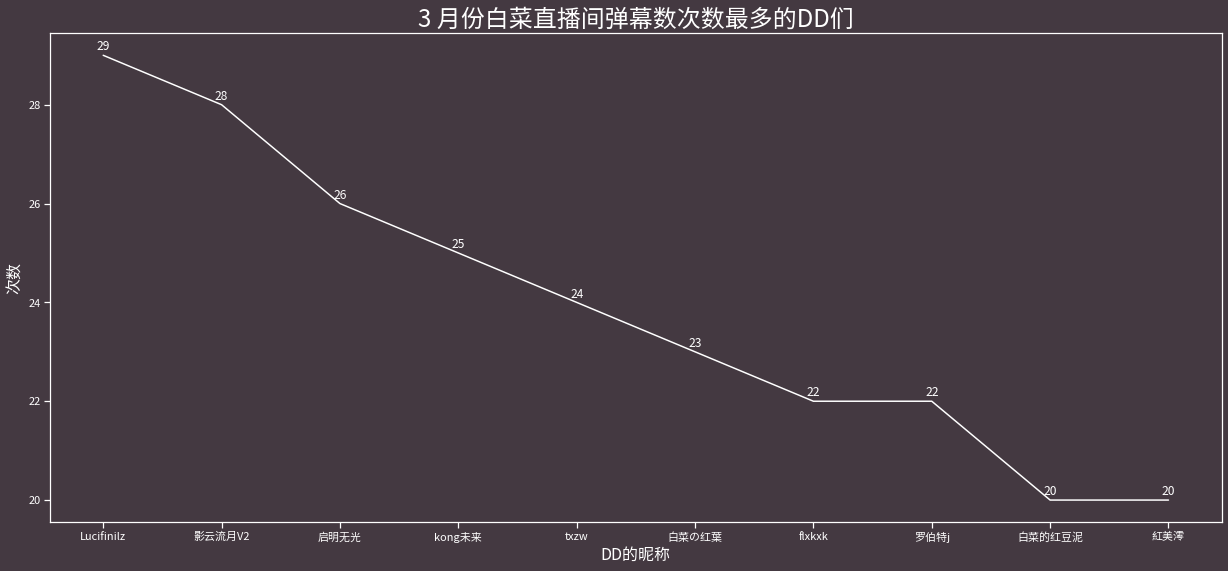

In [5]:
roomid = "21402309"
year = 2021
month = 3
topn = 50
days = calendar.monthrange(year, month)[-1]
dd_info = {}
# 每天的弹幕数
month_danmaku_nums = []

for day in range(1, days+1):
    date = f"{year}-{month}-{day}"
    dd_list, num = topn_dd_of_one_day(roomid, date, topn)
    month_danmaku_nums.append(num)
    dd_list.sort(key=lambda x: x.danmaku_nums, reverse=True)
    for dd in dd_list:
        if dd.uname in dd_info:
            dd_info[dd.uname] += 1
        else:
            dd_info[dd.uname] = 1

# 出现 topn 次数中最多的 10 人
top10_of_topn = Counter(dd_info).most_common(10)

x = []
y = []
for x1, y1 in top10_of_topn:
    x.append(x1)
    y.append(y1)

plt.figure(figsize=(21, 9))
plt.plot(x, y, label="3月弹幕数次数最多的DD们", color="white")
plt.xlabel("DD的昵称", fontsize=16)
plt.ylabel("次数", fontsize=16)
plt.title("3 月份白菜直播间弹幕数次数最多的DD们", fontsize=24)
# 图上画出数据
for i in range(len(x)):
    plt.text(i, y[i] + 0.1, y[i], ha="center", fontsize=12)
plt.show()

### 获取 3 月份白菜直播间每天的发过弹幕的人数变化

注意先运行上面的 cell 获取 month_dates、month_danmaku_nums 等数据

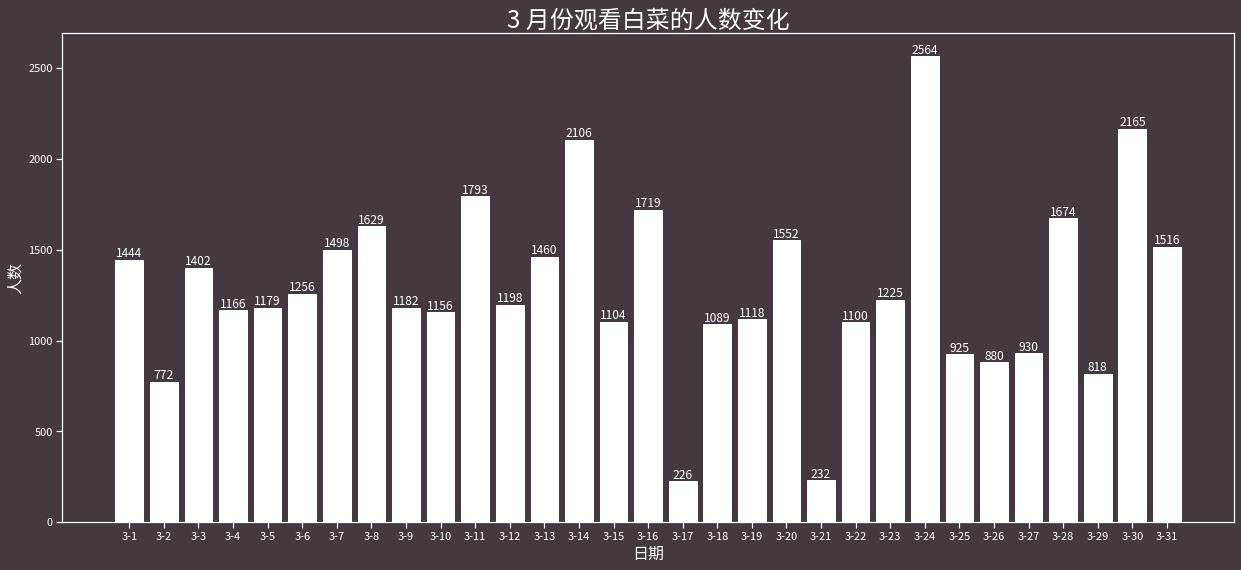

In [6]:
# 注意先运行上面的 cell 获取数据
month_dates = [f"{month}-{day}" for day in range(1, days+1)]

plt.figure(figsize=(21, 9))
plt.bar(month_dates, month_danmaku_nums, label="3月弹幕数次数最多的DD们", color="white")
plt.xlabel("日期", fontsize=16)
plt.ylabel("人数", fontsize=16)
plt.title("3 月份观看白菜的人数变化", fontsize=24)
for i in range(len(month_dates)):
    plt.text(i, month_danmaku_nums[i] + 15,
             month_danmaku_nums[i], ha="center", fontsize=12)
plt.show()

### 一天的弹幕词云图

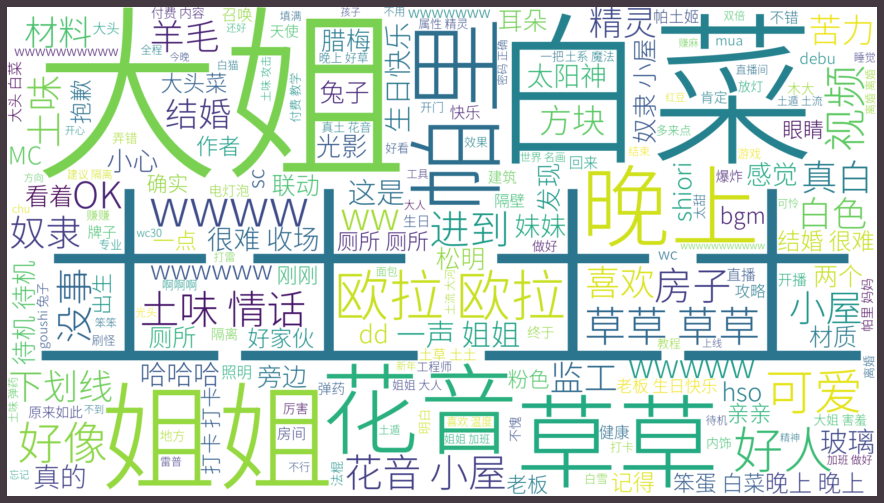

In [7]:
def save_danmakus(roomid: str, date: str,) -> None:
    """
    获取 vup 某天的弹幕并另存为文本

    @roomid: 直播间 id
    @date: 日期（2021-3-10）
    """
    dd_danmakus = []

    filename = f"{roomid}/{date}.txt"
    dst_filename = f"{roomid}_{date}_purge.txt"
    if not os.path.exists(filename):
        return
    with open(filename, encoding="utf-8") as fp:
        for line in fp:
            # 开始为时间戳的留下来，由于源文件中存在其他数据
            # 如 TIME20:xxx 和最后一行的总结，这些我不需要
            if not line.startswith("16"):
                continue
            danmaku = "".join(line.split(":")[2:]).replace("\n", "").strip()
            dd_danmakus.append(danmaku)

    with open(dst_filename, "w", encoding="utf-8") as fp:
        fp.write("".join(dd_danmakus))


def draw_cloud(
    filename: str,
    font_path: str = "SourceHanSansCN-Light.otf",
    image_path: str = "",
    color: str = "#FFFFFF",
):
    """
    画指定文件的词云图

    @filename: 弹幕文件路径
    @font_path: 字体路径
    @image_path: 背景图片
    @color: 十六进制颜色
    """
    if not os.path.exists(filename):
        return
    with open(filename, encoding="utf-8") as fp:
        text = fp.read()
    # 中文分词
    seg_list = jieba.cut(text, cut_all=False)

    with open("stopwords.txt", encoding="utf-8") as fp:
        stop_seg_list = fp.read().splitlines()

    # 把文本中的 stopword 剃掉
    my_word_list = []

    for my_word in seg_list:
        if len(my_word.strip()) > 1 and not my_word.strip() in stop_seg_list:
            my_word_list.append(my_word)

    if not os.path.exists("images"):
        os.mkdir("images")

    my_word_str = " ".join(my_word_list)

    purge_name = os.path.splitext(filename)[0]
    dst_filename = f"{purge_name}_wordcloud"
    idx = 1
    while os.path.exists(f"images/{dst_filename}.png"):
        dst_filename = f"{purge_name}_wordcloud_{idx}"
        idx += 1

    if image_path:
        wc = WordCloud(
            font_path=font_path,
            background_color=color,
            mask=imread(image_path),
        )
    else:
        wc = WordCloud(
            font_path=font_path,
            background_color=color,
            random_state=1024,
            width=1920,
            height=1080,
        )
    try:
        wc.generate(my_word_str)
        # 保存
        # wc.to_file(f"images/{dst_filename}.png")
        # 显示
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
    except Exception as e:
        print(e)


roomid = "21402309"
date = "2021-3-10"
save_danmakus(roomid, date)
draw_cloud(f"{roomid}_{date}_purge.txt")